<a href="https://colab.research.google.com/github/LucasBezerraSantos/Alura_Machine_Learning/blob/master/Deteccao_de_fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraude Bancária

O presente projeto tem como objetivo criar um modelo de Machine Learning capaz de detectar e classificar ocorrências de fraude bancária. Devido à grande quantidade de transações realizadas em bancos, não é possível investigar com eficiência todos os registros e classificá-los sem auxílio da tecnologia. Porém, através de técnicas de aprendizado de máquina (Machine Learning), é possível construir um modelo que reconheça padrões inadequados nas transações e informe as ocorrências de fraude.

Para a definição das regras que constituem fraude, deve-se realizar um trabalho conjunto com as áreas de negócio, assim como também deve haver um estudo das características comuns dos principais casos de fraude detectados pela empresa.

Após a definição das regras, inicia-se o processo de **ETL** (Extração, Transformação e Leitura de Dados) para construção da Base de Dados. As etapas seguintes para o desenvolvimento da solução seguem a metodologia de Projetos e Mineração de Dados **CRISP-DM**:

1.   Entendimento do Negócio.
2.   Entendimento dos Dados.
3.   Preparação dos Dados.
4.   Modelagem.
5.   Avaliação.
6.   Implantação.

OBS *Cada funcionalidade utilizada abaixo pode ser lida através da documentação oficial na internet, devido este projeto se ater ao estudo de caso, o ensino das funcionalidades da linguagem não é apresentado.*

## Etapa I - Leitura e Tratamento de Dados (modelagem)

Nesta etapa o conjunto de dados é avaliado. A etapa de tratamento e transformação de dados é crucial no processo de Machine Learning. Ela envolve a limpeza dos dados, removendo valores ausentes ou inconsistentes, assim como a padronização e normalização das variáveis. Além disso, é nessa etapa que ocorre a codificação de variáveis categóricas e a seleção de features relevantes. Essas transformações garantem a qualidade dos dados utilizados para treinar o modelo e aumentam sua capacidade de generalização.

### Leitura de Dados

**O conjunto de dados é composto pelas seguintes informações:**

`Passo` - Unidade de Tempo (1 hora)

`tipo` - CASH-IN, CASH-OUT, DÉBITO, PAGAMENTO e TRANSFERÊNCIA.

`Valor` - Valor da transação em moeda local.

`nameOrig` - originador da transação

`oldbalanceOrg` - saldo inicial (antes da transação)

`newbalanceOrig` - novo saldo (após transação)

`nameDest` - destinatário da transação

`oldbalanceDest` - saldo inicial antes da transação.

`newbalanceDest` - novo saldo após a transação.

`isFraud` - O agente de fraude assume o controle das contas dos clientes e tenta esvaziá-las transferindo para outra conta e, em seguida, sacando.

`isFlaggedFraud` - Uma tentativa ilegal de transferir uma enorme quantidade de dinheiro em uma única transação.

Fonte: https://www.kaggle.com/datasets/gopalmahadevan/fraud-detection-example


São importadas as Bibliotécas Python para trabalhar com os dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

O conjunto de dados é armazenado na variável "dados" através do link com a função read_csv.

In [2]:
dados = pd.read_csv('/content/sample_data/fraud_dataset_example.csv')

In [3]:
!pip install pandas-profiling
import pandas_profiling

<ipython-input-3-b5dbd5679c69>:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Resumo geral dos dados

In [4]:
pandas_profiling.ProfileReport(dados)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Transformação de Dados

Essa etapa é muito importante para limpeza, regularização e organização das informações

Abaixo as colunas do conjunto de dados são reordenadas para que as informações de fraude estejam na primeira posição.



In [5]:
dados = dados[['isFraud', 'isFlaggedFraud', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest']]

A seguir é feita a tradução dos nomes de colunas para **Português**, com o objetivo de facilitar a leitura.

In [6]:
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

Tradução de colunas

In [7]:
dados = dados.rename(columns = colunas)
dados.head()

,fraude,super_fraude,tempo,tipo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2
0,0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,0,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,0,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


Verificando se há dados nulos: valores nulos com grande frequência dificultam o reconhecimento de padrões e por esse motivo, se houver, devem ser regularizados.

In [8]:
dados.isnull().sum() # contabiliza a quantidade de valores nulos

fraude              0
super_fraude        0
tempo               0
tipo                0
valor               0
cliente1            0
saldo_inicial_c1    0
novo_saldo_c1       0
cliente2            0
saldo_inicial_c2    0
novo_saldo_c2       0
dtype: int64

Limpeza de dados

Existem informações que não contribuem para o aprendizado de máquina, por exemplo o "nome do cliente". Deve-se simplificar a base de dados para que o algoritmo busque padrões de fraude e os replique para casos futuros. O nome é subjetivo, e uma transação não pode ser classificada com base no nome de pessoas, por esse motivo essa informação é excluida do conjunto de dados.

A coluna "superfraude" também é excluida porque não há registros.

In [9]:
dados = dados.drop(['cliente1', 'cliente2', 'super_fraude'], axis = 1)

Encoding

A codificação (encoding) é essencial em Machine Learning para transformar dados categóricos em formatos numéricos compreensíveis pelos algoritmos. Isso permite que as informações relevantes sejam consideradas durante o treinamento dos modelos. A codificação adequada ajuda a evitar a perda de informações e melhora a precisão dos resultados. "Grosso modo" um exemplo de codificação é atribuir 1 quando acontecer um evento e 0 quando não ocorrer, deste modo o algoritmo poderá aprender com os padrões dos eventos.






In [10]:
dados = pd.get_dummies(data=dados, columns=['tipo'], dtype=int)
dados.head()
# a coluna tipo é separada e codificada de acordo com a ocorrência do tipo de transação

,fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,0,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,0,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


##Etapa II - Treino e Teste

A etapa de treino e teste é fundamental no desenvolvimento de Machine Learning. Durante o treino, um modelo é alimentado com dados de treinamento para aprender padrões e relacionamentos entre as variáveis. Após o treinamento, o modelo é avaliado usando um conjunto separado de dados de teste para medir sua capacidade de generalização. A divisão entre treino e teste ajuda a verificar se o modelo está performando bem em dados não vistos previamente. Essa etapa é importante para evitar overfitting, onde o modelo se ajusta demais aos dados de treinamento e não consegue generalizar para novos dados.






Abaixo os dados de treinamento do algoritmo são armazenados em X e a variável alvo, que contém as informações de fraude, são armazenadas em y.

In [11]:
X = dados.drop(columns='fraude', axis=1 )
y = dados.fraude

In [12]:
# chamada de recursos da bibliotéca sklearn para aplicação do modelo de Regressão Logística

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [13]:
# definição de parâmetros do modelo

SEED = 42
lr = LogisticRegression(max_iter=1000, random_state=SEED)

Abaixo, o conjunto de dados é separado em grupos diferentes para aplicação de modo particionado e depois validado com dados não vistos.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.25, random_state=SEED)

lr.fit(X_train, y_train)
previsoes = lr.predict(X_test)

acuracia = metrics.accuracy_score(y_test, previsoes)
precisao = metrics.precision_score(y_test, previsoes)
sensibilidade = metrics.recall_score(y_test, previsoes)
f1_score = metrics.f1_score(y_test, previsoes)

print(
    f'Acuracia: {acuracia:.2f} \n'
    f'Precisao: {precisao:.2f} \n'
    f'Sensibilidade: {sensibilidade:.2f} \n'
    f'f1_score: {f1_score:.2f} \n'
      )

Acuracia: 1.00 
Precisao: 0.20 
Sensibilidade: 0.04 
f1_score: 0.07 



A avaliação de resultados é um ponto muito importante em ciência de dados, com frequência, resultados "perfeitos" indicam que são "imperfeitos". Acima, o resultado aponta 100% de acurácia, isso significa que o modelo conseguiu classificar todos os dados "corretamente", mas ele foi apenas 20% preciso, e teve apenas 4% de sensibilidade.

Ver: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

### Visualização

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import make_classification
%matplotlib inline

`Abaixo é apresentada a Matriz de Confusão, ela contém as seguintes informações:`

O primeiro quadrado mostra os **VERDADEIROS NEGATIVOS**: O número de registros classificados corretamente sem Fraude.

O segundo quadrado mostra os **FALSOS POSITIVOS**: O número de registros acusados como fraude indevidamente.

O terceiro quadrado mostra os **FALSOS NEGATIVOS**: O número de registros que possuem Fraude mas não foram classificados corretamente pelo modelo.

O quarto quadrado mostra os **VERDADEIROS POSITIVOS**: Número de casos de fraude identificados corretamente.

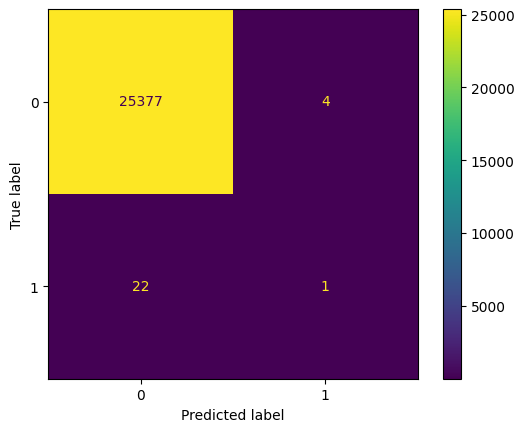

In [16]:
cm = confusion_matrix(y_test, previsoes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**Dados desbalanceados**

O motivo da baixa performance do modelo é seu desbalanceamento. Quando o conjunto de dados possuí muitas amostras de um itém (ausência de fraude) e poucos de outro itém (casos de fraude) ele tende a se super-ajustar aos casos mais frequêntes e fica enviezado.

Para resolver este caso deve-se balancear de modo que os dados sejam proporcionalmente compatíveis.

In [17]:
dados.fraude.value_counts() # número de casos sem fraude ( 0 ), registros de fraude ( 1 )

0    101497
1       116
Name: fraude, dtype: int64

## Etapa III - Balanceamento de dados

O balanceamento de dados é importante porque muitos algoritmos de Machine Learning são sensíveis a desequilíbrios nos dados de treinamento. Isso significa que eles podem ser prejudicados ou produzir resultados imprecisos se a proporção de amostras de diferentes classes não for adequada. Por essas razões, é importante equilibrar os dados antes de rodar o algoritmo de Machine Learning.



**Obtenção de recursos**.

In [18]:
!pip install -U imbalanced-learn

In [19]:
from imblearn.over_sampling import SMOTE
import numpy as np

SMOTE - Synthetic Minority Over-sampling Technique: Criar novas amostras sintéticas para a classe sub-representada e ajuda a equilibrar as classes.

In [20]:
smote = SMOTE(random_state=SEED)

x = dados.drop('fraude', axis=1)
y = dados['fraude']

Aplicação SMOTE

In [21]:
x_resampled, y_resampled = smote.fit_resample(x, y)
df_balanced = pd.concat([y_resampled, x_resampled], axis=1)

Perceba abaixo que após a aplicação da função SMOTE os dados de Fraude e Transações Regulares foram proporcionalmente equiparadas.

In [22]:
df_balanced.groupby('fraude').tempo.count()

fraude
0    101497
1    101497
Name: tempo, dtype: int64

Após a transformação, novamente são separados os conjuntos de treino e teste para aplicação do modelo.

In [23]:
x = df_balanced.iloc[:, 1:].values
y = df_balanced.iloc[:, 0].values

In [24]:
SEED = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = SEED)

lr.fit(x_train, y_train)
y_pred =lr.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


Observe que embora a acurácia tenha diminuído, as demais métricas aumentaram muito! Isso ocorreu porque o modelo teve mais dados de exemplo para classifcar transações regulares e fraudes.

### Visualização

`Abaixo é apresentada a Matriz de Confusão, ela contém as seguintes informações:`

O primeiro quadrado mostra os **VERDADEIROS NEGATIVOS**: O número de registros classificados corretamente sem Fraude.

O segundo quadrado mostra os **FALSOS POSITIVOS**: O número de registros acusados como fraude indevidamente.

O terceiro quadrado mostra os **FALSOS NEGATIVOS**: O número de registros que possuem Fraude mas não foram classificados corretamente pelo modelo.

O quarto quadrado mostra os **VERDADEIROS POSITIVOS**: Número de casos de fraude identificados corretamente.

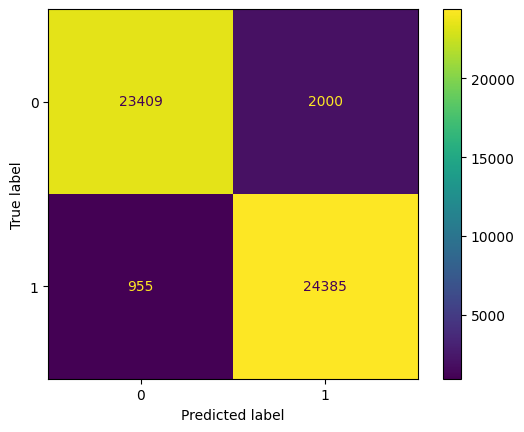

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**GRÁFICO CURVA ROC**

A curva ROC (Receiver Operating Characteristic) é um gráfico que representa a performance de um modelo de classificação binária em diferentes pontos de corte do limiar de decisão. A área sob a curva ROC (AUC-ROC) é uma medida da capacidade discriminativa do modelo, indicando o quão bem ele é capaz de distinguir entre as classes.

A curva ROC é útil para avaliar e comparar diferentes modelos, permitindo identificar o trade-off entre taxa de verdadeiros positivos e taxa de falsos positivos. Quanto maior a área sob a curva, melhor é o desempenho do modelo.

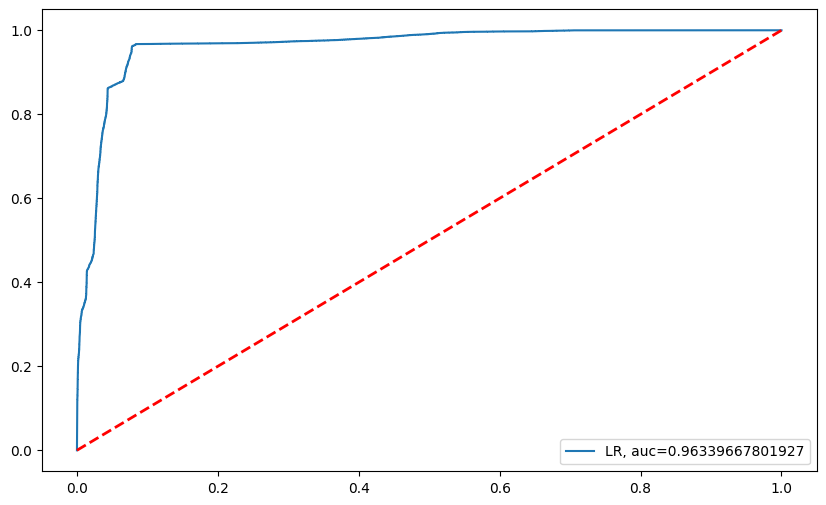

In [26]:
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (10., 6.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

## Etapa IV - Testando novos modelos

Antes de concluir um projeto de Machine Learning é importante testar diferentes modelos de classificação para obter a melhor métrica possível.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### DecisionTreeClassifier

O DecisionTreeClassifier é um algoritmo que usa uma única árvore para classificar os dados de entrada em diferentes categorias. Ele divide recursivamente os dados em subconjuntos menores com base em determinadas condições, até que as amostras em cada subconjunto sejam suficientemente homogêneas para serem rotuladas com uma categoria.

In [28]:
modelo_dt = DecisionTreeClassifier(random_state=SEED, min_samples_split=100)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
...     x, y, test_size=0.25, random_state=SEED)

modelo_dt.fit(X_train, y_train)
previsoes = modelo_dt.predict(X_test)

acuracia = metrics.accuracy_score(y_test, previsoes)
precisao = metrics.precision_score(y_test, previsoes)
sensibilidade = metrics.recall_score(y_test, previsoes)
f1_score = metrics.f1_score(y_test, previsoes)

print(
    f'Acuracia: {acuracia:.5f} \n'
    f'Precisao: {precisao:.5f} \n'
    f'Sensibilidade: {sensibilidade:.5f} \n'
    f'f1_score: {f1_score:.5f} \n'
      )

Acuracia: 0.99527 
Precisao: 0.99374 
Sensibilidade: 0.99680 
f1_score: 0.99527 



### RandomForestClassifier

O Random Forest é um algoritmo de aprendizado de máquina que usa várias árvores de decisão para realizar tarefas de classificação ou regressão. Ele combina as previsões de várias árvores de decisão individuais para chegar a uma previsão final. Cada árvore é treinada em uma amostra aleatória dos dados de entrada e com um conjunto aleatório de recursos, o que aumenta a diversidade das árvores e reduz o risco de overfitting.

In [30]:
modelo_rf = RandomForestClassifier(random_state=SEED, min_samples_split=100)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
...     x, y, test_size=0.25, random_state=SEED)

modelo_rf.fit(X_train, y_train)
previsoes = modelo_rf.predict(X_test)

acuracia = metrics.accuracy_score(y_test, previsoes)
precisao = metrics.precision_score(y_test, previsoes)
sensibilidade = metrics.recall_score(y_test, previsoes)
f1_score = metrics.f1_score(y_test, previsoes)

print(
    f'Acuracia: {acuracia:.5f} \n'
    f'Precisao: {precisao:.5f} \n'
    f'Sensibilidade: {sensibilidade:.5f} \n'
    f'f1_score: {f1_score:.5f} \n'
      )

Acuracia: 0.99817 
Precisao: 0.99736 
Sensibilidade: 0.99897 
f1_score: 0.99817 



### XGBClassifier

O XGBClassifier é um modelo de classificação baseado em gradient boosting, conhecido como Extreme Gradient Boosting. Ele utiliza uma técnica de aprendizado de máquina chamada boosting para combinar vários modelos fracos em um modelo forte.

O XGBClassifier é capaz de lidar com problemas de classificação binária e multiclasse. Ele utiliza árvores de decisão como estimadores base e, através do processo de boosting, melhora iterativamente o desempenho do modelo.

In [32]:
modelo_xgb = XGBClassifier(n_estimators=100, random_state=SEED)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
...     x, y, test_size=0.25, random_state=SEED)

modelo_xgb.fit(X_train, y_train)
previsoes = modelo_xgb.predict(X_test)

acuracia = metrics.accuracy_score(y_test, previsoes)
precisao = metrics.precision_score(y_test, previsoes)
sensibilidade = metrics.recall_score(y_test, previsoes)
f1_score = metrics.f1_score(y_test, previsoes)

print(
    f'Acuracia: {acuracia:.5f} \n'
    f'Precisao: {precisao:.5f} \n'
    f'Sensibilidade: {sensibilidade:.5f} \n'
    f'f1_score: {f1_score:.5f} \n'
      )

Acuracia: 0.99911 
Precisao: 0.99838 
Sensibilidade: 0.99984 
f1_score: 0.99911 



### Visualização de Resultados

In [34]:
classifiers = [
    DecisionTreeClassifier(random_state=SEED, min_samples_split=100),
    RandomForestClassifier(random_state=SEED, min_samples_split=100),
    XGBClassifier(n_estimators=100, random_state=SEED)]

DecisionTreeClassifier
****Resultados****
Accuracy:, 0.99527
Precision:, 0.99374
Recall:, 0.99680
F1:, 0.99527
RandomForestClassifier
****Resultados****
Accuracy:, 0.99817
Precision:, 0.99736
Recall:, 0.99897
F1:, 0.99817
XGBClassifier
****Resultados****
Accuracy:, 0.99911
Precision:, 0.99838
Recall:, 0.99984
F1:, 0.99911


<Figure size 800x600 with 0 Axes>

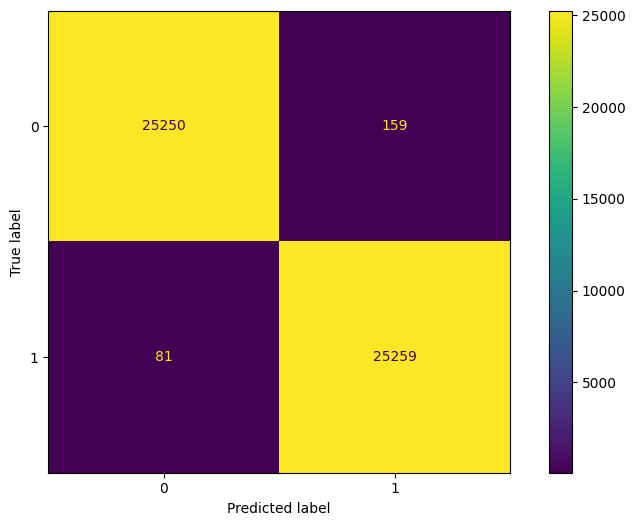

<Figure size 800x600 with 0 Axes>

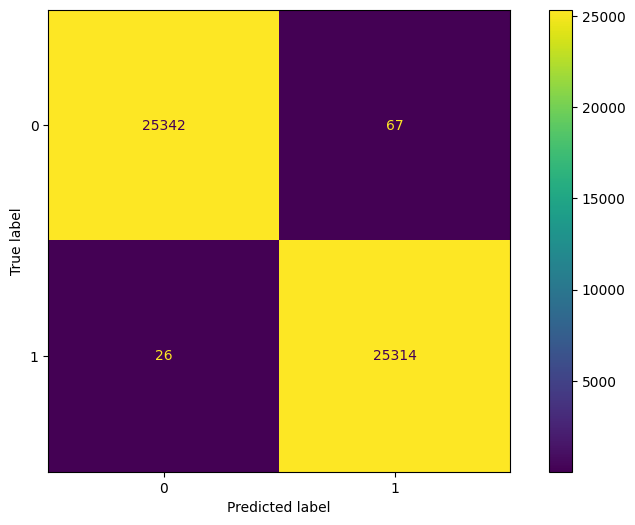

<Figure size 800x600 with 0 Axes>

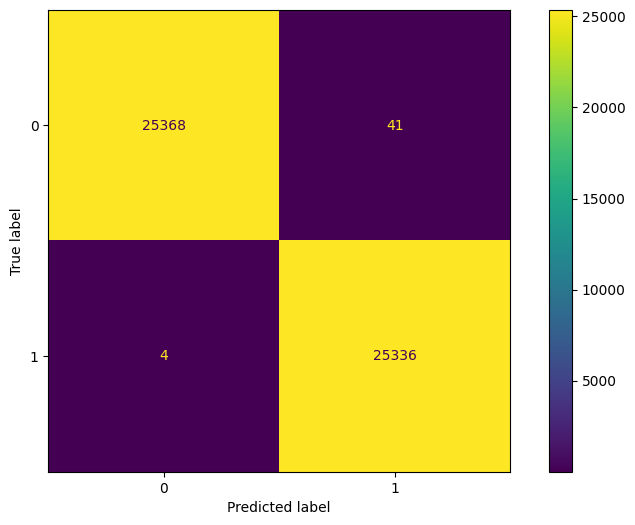

In [35]:
for clf in classifiers:
  clf.fit(x_train, y_train)
  name = clf.__class__.__name__

  print("="*30)
  print(name)
  print('****Resultados****')
  y_pred = clf.predict(x_test)
  print(f"Accuracy:, {metrics.accuracy_score(y_test, y_pred):.5f}")
  print(f"Precision:, {metrics.precision_score(y_test, y_pred):.5f}")
  print(f"Recall:, {metrics.recall_score(y_test, y_pred):.5f}")
  print(f"F1:, {metrics.f1_score(y_test, y_pred):.5f}")

  plt.figure(figsize=(8,6))
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

## Etapa V - Otimização de híper-parâmetros

Quando os dados são separados em Treino e Teste, essa seração é realizada de modo aleatório, e embora este projeto tenha aplicado o SEED para que seja possível reproduzi-lo em outros computadores com as mesmas métricas, o que aconteceria se fossem usados dados diferentes para treinar e testar o modelo? Os resultados seriam diferentes.

**Para resolver essa questão**, aplicar-se-á a validação cruzada, onde diferentes partes dos dados são usados para treino e teste. No final, o algoritmo retorna uma métrica representativa dos diferentes testes realizados, tornando-se mais factível.

A validação cruzada será aplicada dentro do RandomizedSearchCV, que aplicará diferentes parâmetros no modelo.

In [36]:
dicionario_parametros_xgb = {
    "n_estimators": np.arange(100, 250, step=20),
    "learning_rate": np.arange(0.01, 0.1, step=0.02),
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.8, 1, 1.5],
    "colsample_bytree": [0.8, 1, 1.5],
    "reg_alpha": np.arange(0.0, 0.8, step=0.2),
    "reg_lambda": np.arange(0.0, 0.8, step=0.2)
}

In [37]:
from sklearn.model_selection import RandomizedSearchCV

É aplicado o modelo XGB com os parâmetros definidos acima em `dicionario_parametros_xgb`, ele fará 5 iterações diferentes.

In [38]:
random_cv = RandomizedSearchCV(modelo_xgb, dicionario_parametros_xgb, n_iter=5, n_jobs=-1, random_state=SEED)

In [39]:
random_cv.fit(x_train, y_train)
previsoes_xgb = random_cv.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 620, in inner_f
  

Rankind de melhores parâmetros

In [40]:
pd.DataFrame(random_cv.cv_results_)[['params', 'rank_test_score']]

,params,rank_test_score
0,"{'subsample': 0.8, 'reg_lambda': 0.2, 'reg_alp...",2
1,"{'subsample': 1.5, 'reg_lambda': 0.4, 'reg_alp...",2
2,"{'subsample': 1.5, 'reg_lambda': 0.0, 'reg_alp...",2
3,"{'subsample': 1.5, 'reg_lambda': 0.60000000000...",2
4,"{'subsample': 0.8, 'reg_lambda': 0.0, 'reg_alp...",1


In [41]:
random_cv.best_params_ # Melhor parâmetro obtido

{'subsample': 0.8,
 'reg_lambda': 0.0,
 'reg_alpha': 0.2,
 'n_estimators': 120,
 'max_depth': 5,
 'learning_rate': 0.049999999999999996,
 'colsample_bytree': 1}

Resultado após otimização

In [42]:
print(f"Accuracy:, {metrics.accuracy_score(y_test, previsoes_xgb):.5f}")
print(f"Precision:, {metrics.precision_score(y_test, previsoes_xgb):.5f}")
print(f"Recall:, {metrics.recall_score(y_test, previsoes_xgb):.5f}")
print(f"F1:, {metrics.f1_score(y_test, previsoes_xgb):.5f}")

Accuracy:, 0.99170
Precision:, 0.98744
Recall:, 0.99605
F1:, 0.99173


## Etapa V - Aplicação final XGBClassifier

Depois de obter as melhores métricas aplicamos o modelo final

In [43]:
best_modelo_xgb = XGBClassifier(**random_cv.best_params_, random_state=SEED)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
...     x, y, test_size=0.25, random_state=SEED)

best_modelo_xgb.fit(X_train, y_train)
previsoes = best_modelo_xgb.predict(X_test)

acuracia = metrics.accuracy_score(y_test, previsoes)
precisao = metrics.precision_score(y_test, previsoes)
sensibilidade = metrics.recall_score(y_test, previsoes)
f1_score = metrics.f1_score(y_test, previsoes)

### Visualização

In [45]:
print(
    f'Acuracia: {acuracia:.5f} \n'
    f'Precisao: {precisao:.5f} \n'
    f'Sensibilidade: {sensibilidade:.5f} \n'
    f'f1_score: {f1_score:.5f} \n'
      )

Acuracia: 0.99170 
Precisao: 0.98744 
Sensibilidade: 0.99605 
f1_score: 0.99173 



<Figure size 800x600 with 0 Axes>

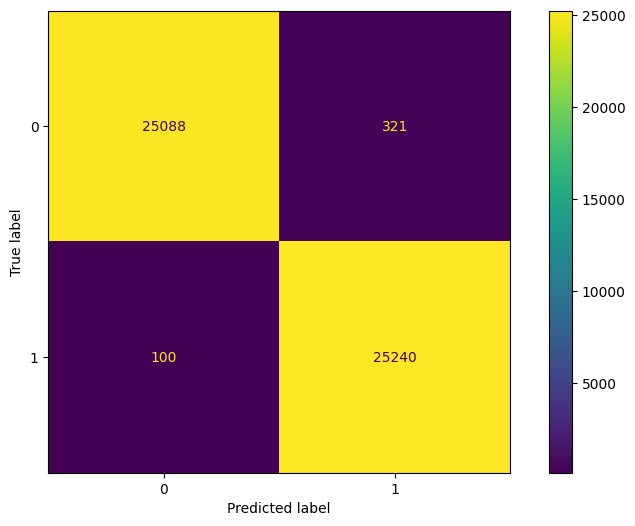

In [46]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, previsoes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [49]:
x_test.shape

(50749, 11)

Após aplicação do modelo final, tivemos apenas 100 casos de fraude classificados como transações normais, e 321 transações normais classificadas como fraude. Totalizando 421 erros.

Considerando que foram classificados 50.749 mil registros, a taxa de erro do algoritmo foi muito baixa e pode ser considerada como boa alternativa de prevenção de fraude no banco.

## Conclusão: Sugestões de combate a fraude bancária

Com base no estudo pode-se apresentar sugestões para o controle de fraude bancária:

1. Monitoramento de Localização: Verificar se a transação foi feita em uma região diferente da habitual do cliente.

2. Análise de Padrões de Comportamento: Identificar compras realizadas em horários atípicos, como durante a madrugada, ou em períodos do mês em que o cliente geralmente não costuma fazer transações.

3. Autenticação Multifatorial: Adotar medidas adicionais de autenticação, como perguntas de segurança personalizadas, que apenas o cliente legítimo seria capaz de responder.

4. Utilizar recursos visuais, como a verificação de imagens (Captcha), para garantir que a transação está sendo realizada por um ser humano e não por um programa automatizado.

5. Monitoramento em Tempo Real: Implementar sistemas de monitoramento em tempo real que possam identificar e bloquear transações suspeitas antes que sejam concluídas, diferentes do que usualmente é realizado pelo cliente.